In [5]:
pip install imutils

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25862 sha256=eb64f5e97d5d6eb13bb71fe03a251c9ba017a6b58e7d1f57a0acc3f54ef73466
  Stored in directory: c:\users\dipesh tiwari\appdata\local\pip\cache\wheels\59\1b\52\0dea905f8278d5514dc4d0be5e251967f8681670cadd3dca89
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opencv-python

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [20]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [21]:
DIRECTORY = r"C:\Users\DIPESH TIWARI\Desktop\FaceMaskDetection-main\data"
CATEGORIES = ["with_mask", "without_mask"]


In [22]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

[INFO] loading images...


In [23]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)


In [24]:
# construct the training image generator for data augmentation
aug = tf.keras.preprocessing.image.ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [25]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = tf.keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))


In [30]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = tf.keras.layers.Flatten(name="flatten")(headModel)
headModel = tf.keras.layers.Dense(128, activation="relu")(headModel)
headModel = tf.keras.layers.Dropout(0.5)(headModel)
headModel = tf.keras.layers.Dense(2, activation="softmax")(headModel)


In [31]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [32]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [34]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] compiling model...


In [35]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(aug.flow(trainX, trainY, batch_size=BS),steps_per_epoch=len(trainX) // BS,validation_data=(testX, testY),
              validation_steps=len(testX) // BS,epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
34/34 [==============================] - 143s 4s/step - loss: 0.5089 - accuracy: 0.7903 - val_loss: 0.2382 - val_accuracy: 0.9746
Epoch 2/20
34/34 [==============================] - 119s 4s/step - loss: 0.2252 - accuracy: 0.9560 - val_loss: 0.1117 - val_accuracy: 0.9819
Epoch 3/20
34/34 [==============================] - 124s 4s/step - loss: 0.1214 - accuracy: 0.9794 - val_loss: 0.0702 - val_accuracy: 0.9855
Epoch 4/20
34/34 [==============================] - 116s 3s/step - loss: 0.0869 - accuracy: 0.9850 - val_loss: 0.0514 - val_accuracy: 0.9891
Epoch 5/20
34/34 [==============================] - 116s 3s/step - loss: 0.0584 - accuracy: 0.9925 - val_loss: 0.0404 - val_accuracy: 0.9928
Epoch 6/20
34/34 [==============================] - 116s 3s/step - loss: 0.0498 - accuracy: 0.9916 - val_loss: 0.0341 - val_accuracy: 0.9928
Epoch 7/20
34/34 [==============================] - 115s 3s/step - loss: 0.0489 - accuracy: 0.9897 - val_loss: 0.0291 - val_accura

In [37]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
print("model evaluated successfully")

[INFO] evaluating network...
9/9 [==============================] - 24s 3s/step
model evaluated successfully


In [38]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [39]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))


              precision    recall  f1-score   support

   with_mask       0.99      1.00      1.00       138
without_mask       1.00      0.99      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



In [40]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")
print("Model saved successfully")

[INFO] saving mask detector model...
Model saved successfully


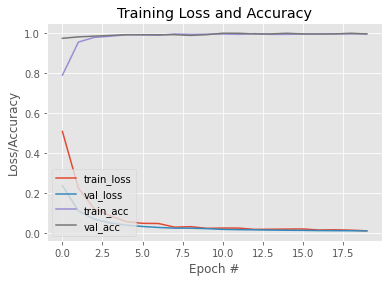

In [41]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")